In [2]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
result_dir = "results"

score_dist_dir = os.path.join(result_dir, "score_dist")
t_test_dir = os.path.join(result_dir, "t_test")

In [4]:
def convert_to_df(ds_name: str, has_gt: bool):
    with open(os.path.join(result_dir, f"{ds_name}.json"), "r") as f:
        score_dict = json.load(f)
    score_df = pd.DataFrame.from_dict(score_dict, orient="index")
    score_MENDER_df = pd.json_normalize(score_df["MENDER"])
    score_MENDER_df.index = score_df.index
    score_MISO_df = pd.json_normalize(score_df["MENDER+MISO"])
    score_MISO_df.index = score_df.index
    
    if has_gt:
        score_df[["nmi_MENDER", "ari_MENDER"]] = score_MENDER_df[["nmi", "ari"]]
        score_df[["nmi_MENDER+MISO", "ari_MENDER+MISO"]] = score_MISO_df[["nmi", "ari"]]

    score_df[["pas_MENDER", "chaos_MENDER"]] = score_MENDER_df[["pas", "chaos"]]
    score_df[["pas_MENDER+MISO", "chaos_MENDER+MISO"]] = score_MISO_df[["pas", "chaos"]]
    
    score_df = score_df.drop(columns=["MENDER", "MENDER+MISO"])

    return score_df

In [5]:
def scatter_plot_scores(score_df, metric:str, title:str=None, save_path:str=None):
    palette = {"MENDER": "tab:red", "MENDER+MISO": "tab:green"}

    fig, ax = plt.subplots()

    X = {
        "MENDER": np.zeros(len(score_df)),
        "MENDER+MISO": np.ones(len(score_df))
    }
    
    for i in range(2):
        ax.axvline(i, color="lightgrey", lw=1, zorder=0)

    
    for method in palette.keys():
        ax.scatter(
            X[method],
            score_df[f"{metric}_{method}"],
            color=palette[method],
            s=50,
            edgecolor="none"
        )
    
    ax.margins(x=0.5)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["MENDER", "MENDER+MISO"])
    ax.set_xlabel("method")
    ax.set_ylabel(metric)

    if title is not None:
        ax.set_title(f"{title}")
    
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=500, bbox_inches='tight', pad_inches=0)

    plt.show()

In [6]:
def box_plot_scores(score_df, metric:str, title:str=None, save_path:str=None):
    palette = {"MENDER": "tab:red", "MENDER+MISO": "tab:green"}

    fig, ax = plt.subplots()

    data = [score_df[f"{metric}_{method}"] for method in palette.keys()]

    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)

    ax.set_xticklabels(["MENDER", "MENDER+MISO"])
    ax.set_xlabel("method")
    ax.set_ylabel(metric)

    if title is not None:
        ax.set_title(f"{title}")
    
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=500, bbox_inches='tight', pad_inches=0)

In [7]:
def ttest_related(score_df, metric:str, alter:str="two-sided"):
    score_1 = score_df[f"{metric}_MENDER"]
    score_2 = score_df[f"{metric}_MENDER+MISO"]

    return stats.ttest_rel(score_1, score_2, alternative=alter)

In [8]:
def hypothesis_testing(ds_name: str, title_name: str, has_gt:bool, ind:bool=True):
    score_df = convert_to_df(ds_name, has_gt=has_gt)

    alter_keys = {
        "pas": "greater",
        "chaos": "greater",
        "nmi": "less",
        "ari": "less"
    }

    result_list = {}

    metrics = ["pas", "chaos"]
    if has_gt:
        metrics = ["pas", "chaos", "nmi", "ari"]

    for metric in metrics:
        scatter_path = os.path.join(score_dist_dir, f"scatter_{ds_name}_{metric}")
        scatter_title = f"Scatter Plot of {metric.upper()} Score on {title_name} Data"
        scatter_plot_scores(score_df, metric, title=scatter_title, save_path=scatter_path)

        box_path = os.path.join(score_dist_dir, f"box_{ds_name}_{metric}")
        box_title = f"Box Plot of {metric.upper()} Score on {title_name} Data"
        box_plot_scores(score_df, metric, title=box_title, save_path=box_path)
        
        t_stat, p_val = ttest_related(score_df, metric=metric, alter=alter_keys[metric])
        result_list[metric] = {
            "t-statistic": float(t_stat),
            "p-value": float(p_val),
        }

    with open(os.path.join(t_test_dir, f"{ds_name}.json"), "w") as f:
        json.dump(result_list, f, indent=4)
    
    return result_list

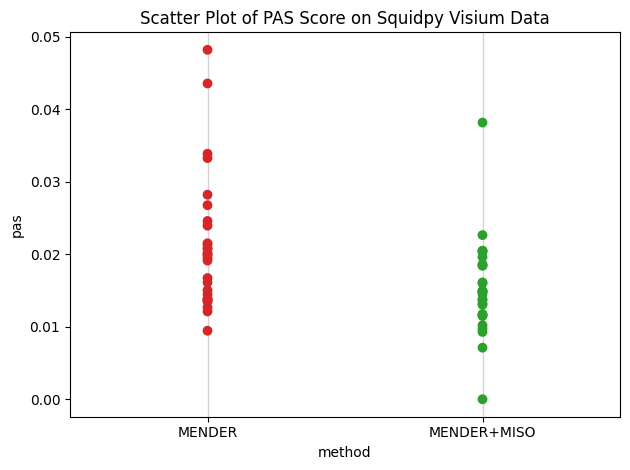

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


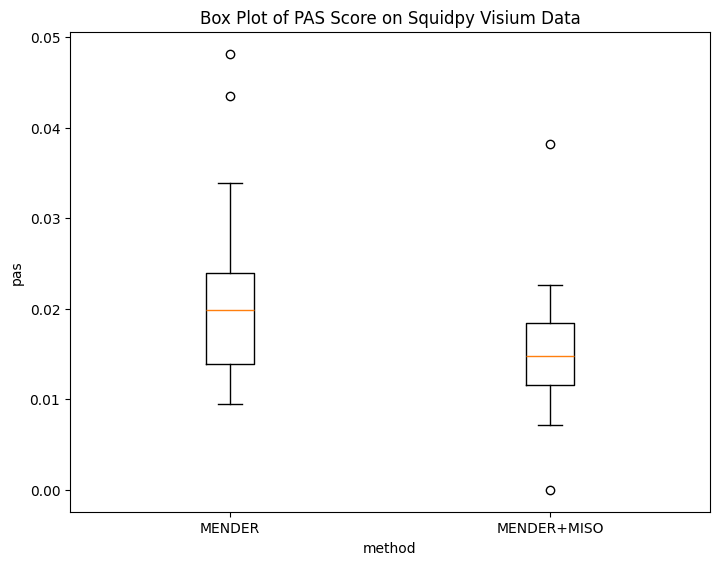

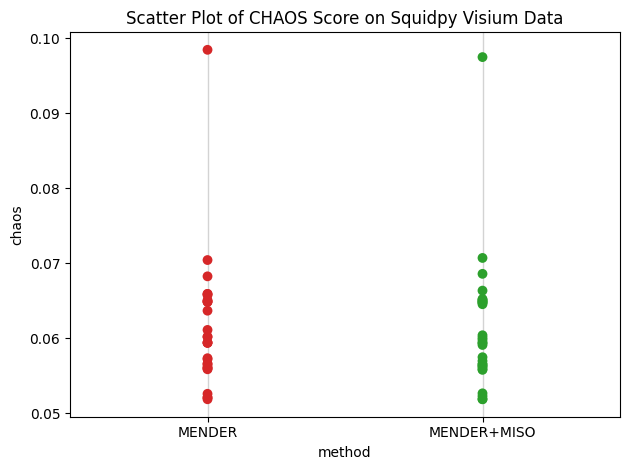

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


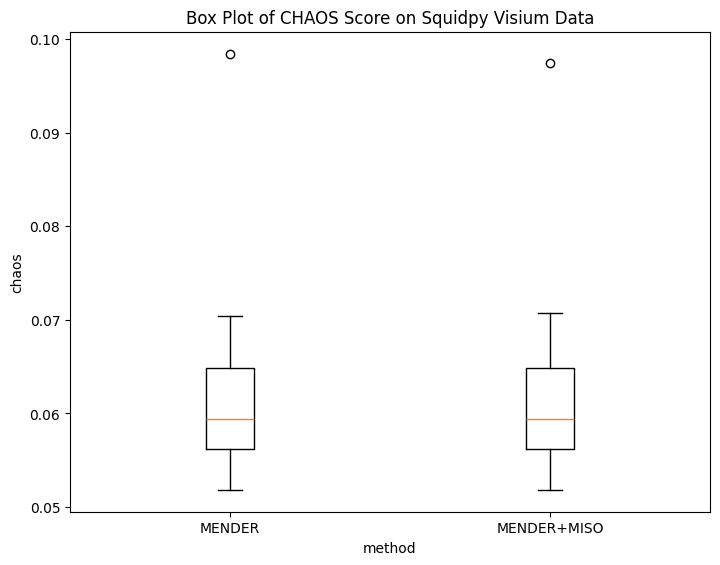

In [9]:
squidpy_visium = hypothesis_testing("squidpy_visium", "Squidpy Visium", has_gt=False)

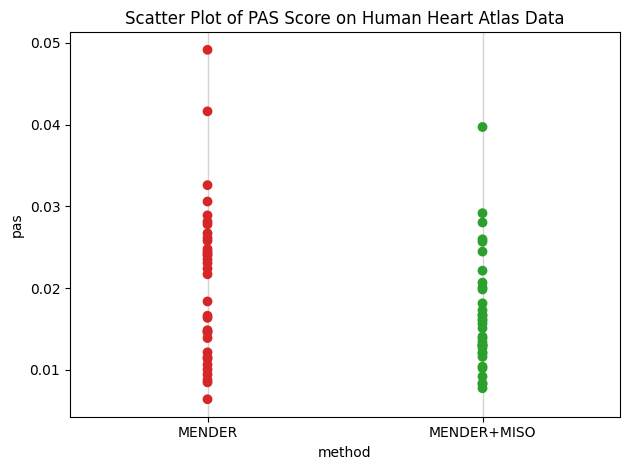

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


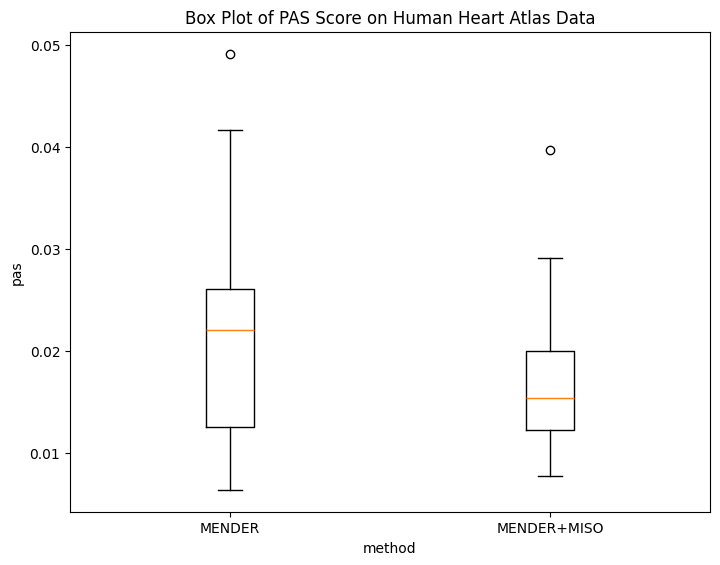

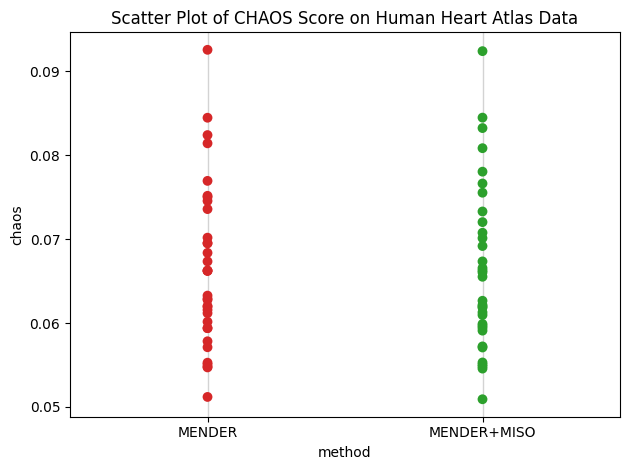

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'pas': {'t-statistic': 2.602707830262853, 'p-value': 0.00687414174212742},
 'chaos': {'t-statistic': 1.1418131253433845, 'p-value': 0.13087471141480894}}

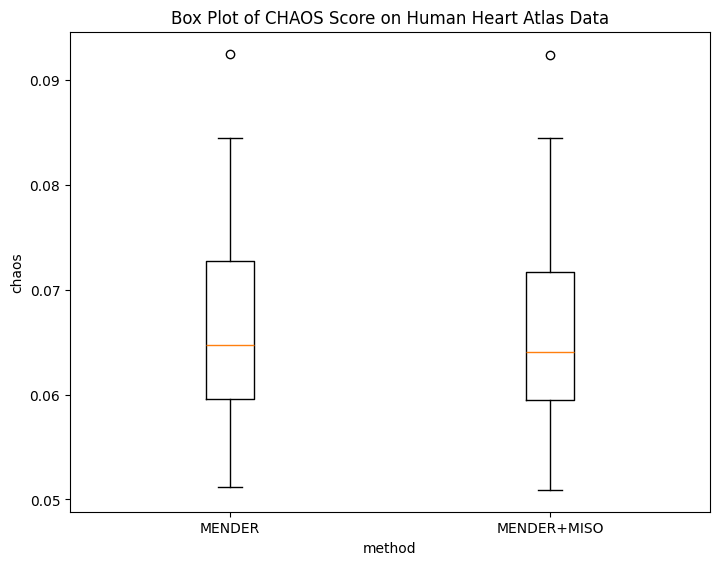

In [10]:
human_heart = hypothesis_testing("human_heart", "Human Heart Atlas", has_gt=False)
human_heart

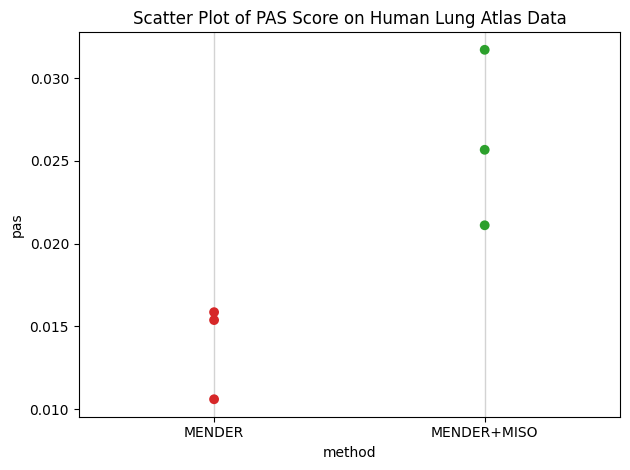

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


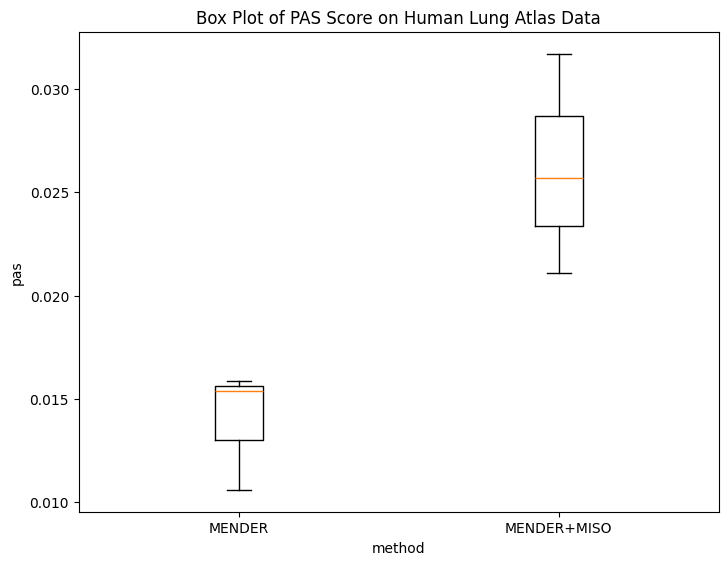

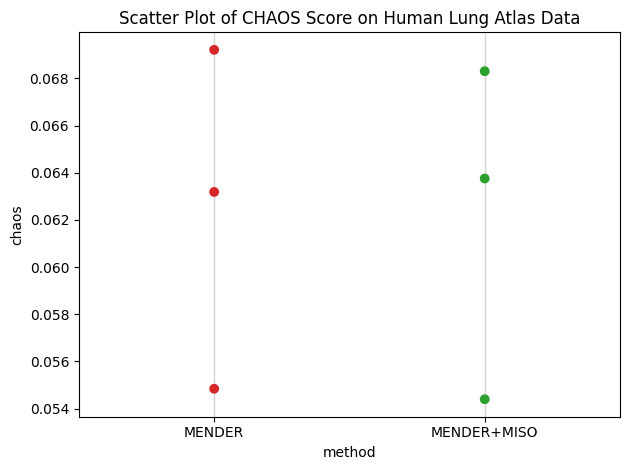

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'pas': {'t-statistic': -3.75618864612191, 'p-value': 0.9679330719684756},
 'chaos': {'t-statistic': 0.5981689926793224, 'p-value': 0.305222021789442}}

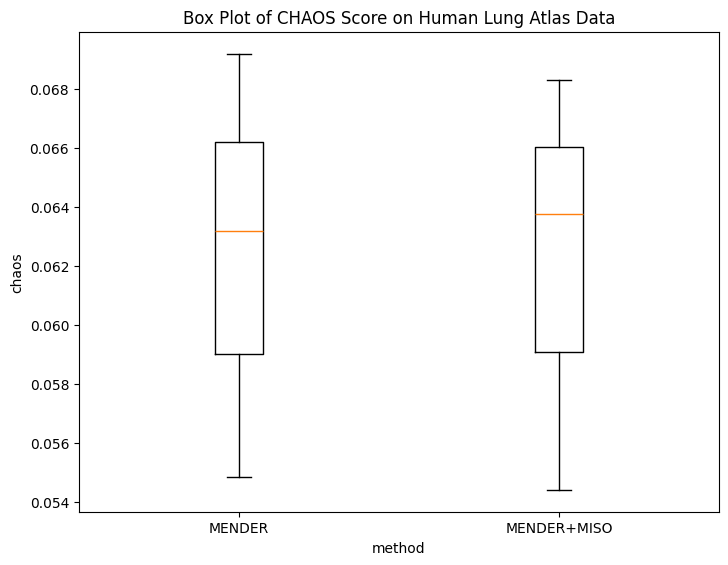

In [11]:
human_lung = hypothesis_testing("human_lung", "Human Lung Atlas", has_gt=False)
human_lung

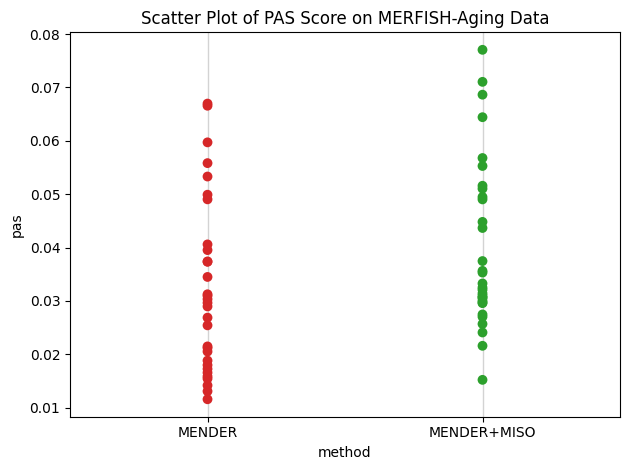

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


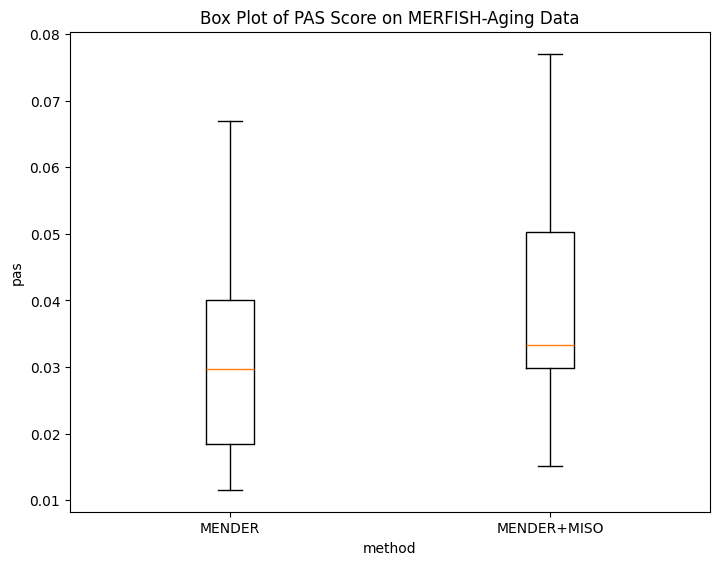

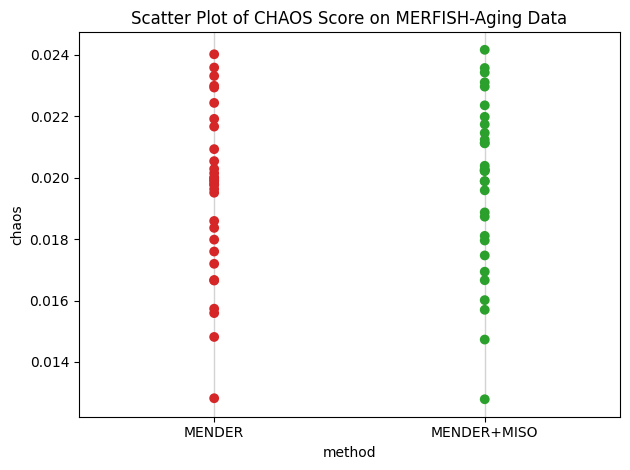

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


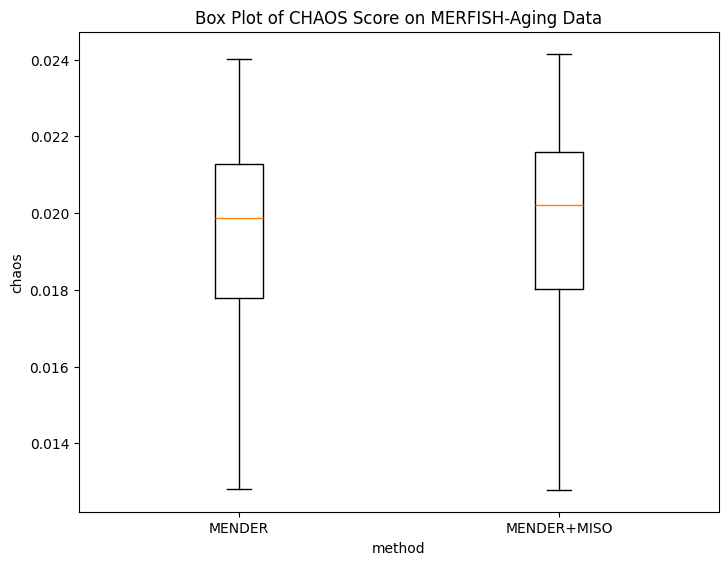

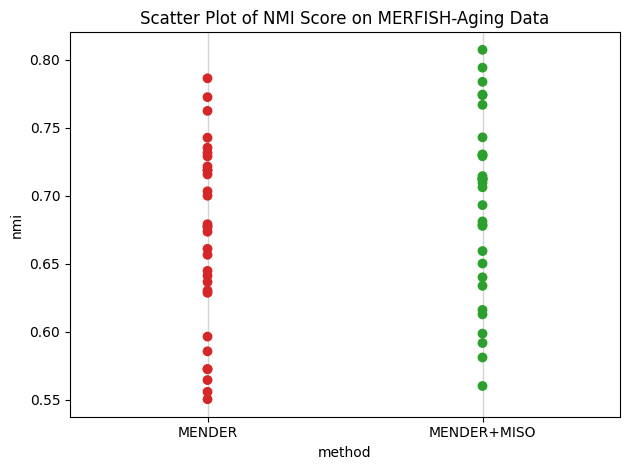

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


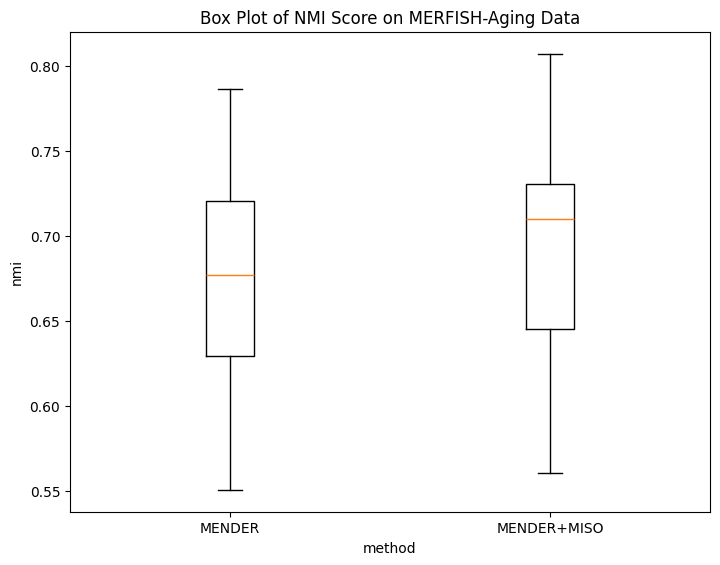

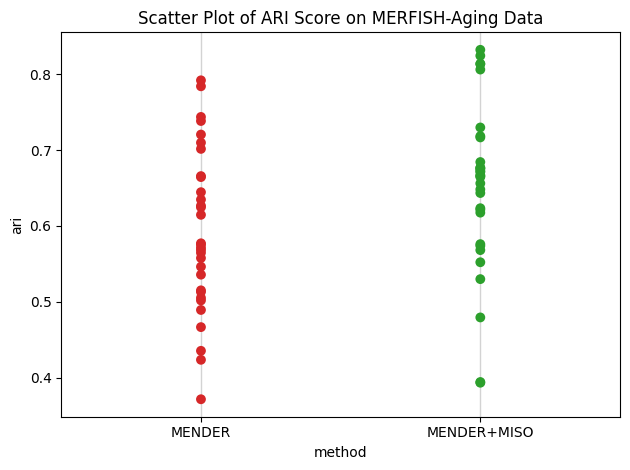

/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_89079/1833824075.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'pas': {'t-statistic': -3.6099971874344603, 'p-value': 0.9994493532633617},
 'chaos': {'t-statistic': -3.667674695743588, 'p-value': 0.9995283604933894},
 'nmi': {'t-statistic': -2.9488790294730594, 'p-value': 0.003063471124259196},
 'ari': {'t-statistic': -3.569706197085544, 'p-value': 0.0006133102775198197}}

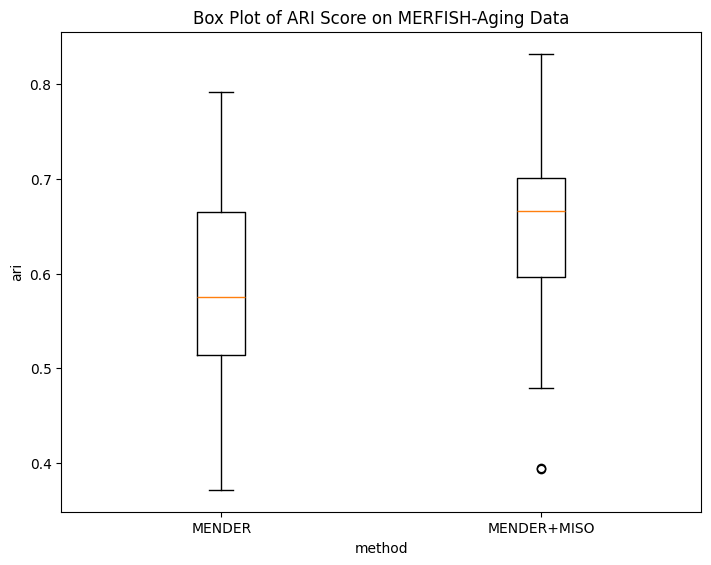

In [12]:
allen_aging = hypothesis_testing("allen_aging", "MERFISH-Aging", has_gt=True)
allen_aging

In [13]:
allen_aging

{'pas': {'t-statistic': -3.6099971874344603, 'p-value': 0.9994493532633617},
 'chaos': {'t-statistic': -3.667674695743588, 'p-value': 0.9995283604933894},
 'nmi': {'t-statistic': -2.9488790294730594, 'p-value': 0.003063471124259196},
 'ari': {'t-statistic': -3.569706197085544, 'p-value': 0.0006133102775198197}}

In [14]:
squidpy_visium

{'pas': {'t-statistic': 2.727009825735817, 'p-value': 0.005452500307474481},
 'chaos': {'t-statistic': 0.8223162121661527, 'p-value': 0.20892248523038814}}

In [15]:
human_heart

{'pas': {'t-statistic': 2.602707830262853, 'p-value': 0.00687414174212742},
 'chaos': {'t-statistic': 1.1418131253433845, 'p-value': 0.13087471141480894}}